This notebook idenfifies useful features for downstream models

In [1]:
from statistics import mean, stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score, accuracy_score,
                             roc_curve, precision_recall_curve)

from sklearn.linear_model import LogisticRegression

from functions.data import numerical_features, make_confusion_matrix
from functions.plotting.mpl import plot_empty, plot_heatmap

In [2]:
save=True

# Get Data

In [3]:
# Import
records_df = pd.read_csv('data/physics.csv')
transforms_df = pd.read_csv('data/physics-transforms.csv')
df = records_df.join(transforms_df.set_index('id_'), on='id_', how='left')
df = df[numerical_features]

In [4]:
# Check if classes are balanced
normalized_target_counts = df.decision.value_counts(normalize=True) 
print(normalized_target_counts)

0    0.533483
1    0.466517
Name: decision, dtype: float64


# Features and K-Fold for Base Features

In [ ]:
# Choose features
features_list = ['gpa', 'gre_verbal', 'gre_quantitative', 'gre_writing', 'gre_subject',
                 'american', 'papers', 'research',]
target = 'decision'

In [5]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
logreg_clf = LogisticRegression(C=1e9)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

In [6]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(
    df.drop(columns=[target]), df[target], test_size=.2, random_state=42)

features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

# Train Logistic Regression

In [7]:
# KFold Cross-Validation with StandardScaler in the loop

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    logreg_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(logreg_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, logreg_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

logreg_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model

print("test_f1_score = ", f1_score(logreg_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, logreg_clf.predict(features_test_scaled_array)))

train_f1_score:  0.5676272425897035  +/-  0.01562108163161059
train_roc_auc_score:  0.5950697021021792  +/-  0.02046734989751102
test_f1_score =  0.581772784019975
test_roc_auc_score =  0.6217815653565756
test accuracy score =  0.581772784019975


# Features and K-Fold for Transformed Features

In [ ]:
# Choose features
features_list = ['gpa', 'gpa_sq', 'gre_verbal', 'gre_quantitative', 'gre_writing_pctl', 'gre_subject', 'grev_x_gres',
                 'american', 'papers', 'research',]
target = 'decision'

In [8]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(
    df.drop(columns = [target]), df[target], test_size=.2, random_state=42)

features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

# Train Logistic Regression

In [9]:
# KFold Cross-Validation with StandardScaler in the loop

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    logreg_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(logreg_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, logreg_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

logreg_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model

print("test_f1_score = ", f1_score(logreg_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, logreg_clf.predict(features_test_scaled_array)))

train_f1_score:  0.567938767550702  +/-  0.0160023456001789
train_roc_auc_score:  0.599494818073607  +/-  0.019696114478304556
test_f1_score =  0.5767790262172284
test_roc_auc_score =  0.6297534044442221
test accuracy score =  0.5767790262172284


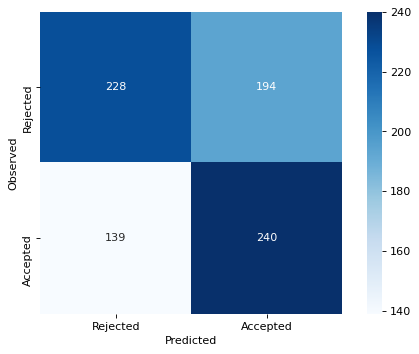

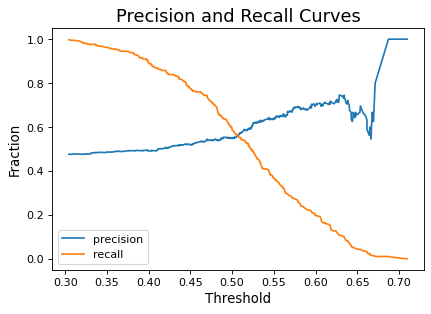

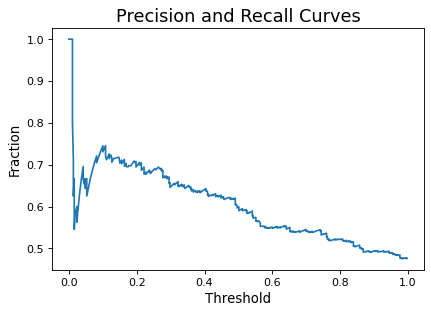

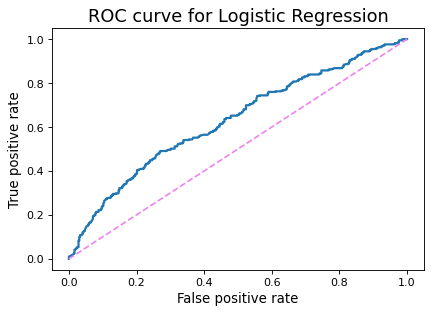

In [10]:
# Confusion Matrix
confusion = make_confusion_matrix(logreg_clf, features_test_scaled_array, target_test_ser, threshold=0.493)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'])
if save:
    plt.savefig("figures/logistic-regression/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/logistic-regression/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/logistic-regression/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve for Logistic Regression', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/logistic-regression/roc.png", transparent=True, bbox_inches="tight")